Total dataset size: 800
Missing target values: 0
Features kept after removing constant features: ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
Selected features after SelectKBest: ['RBC', 'Hb', 'MCV', 'RDW-CV', 'BP', 'Diabetes', 'Age', 'Gender']

--- SVC with GridSearchCV ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Validation Accuracy Scores (5-fold CV): ['74.22%', '72.66%', '78.12%', '77.34%', '78.12%']
Mean CV Accuracy: 76.09%
Standard Deviation of CV Accuracy: 2.24%

Test Accuracy: 78.12%
Test ROC AUC Score: 82.02%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.68      0.76        80
           1       0.73      0.89      0.80        80

    accuracy                           0.78       160
   macro avg       0.79      0.78      0.78       160
weighted avg       0.79      0.78      0.78       160

Predictions saved to predictions_svm_tuned_no_

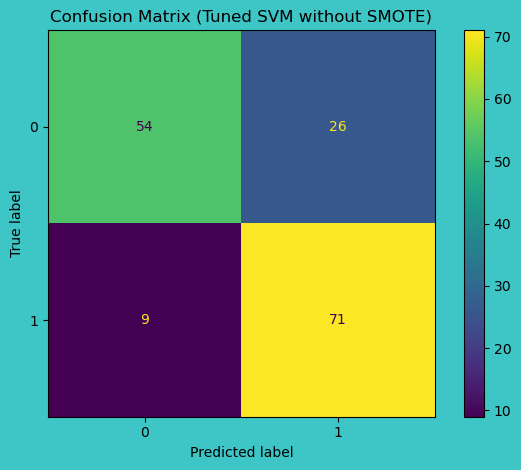

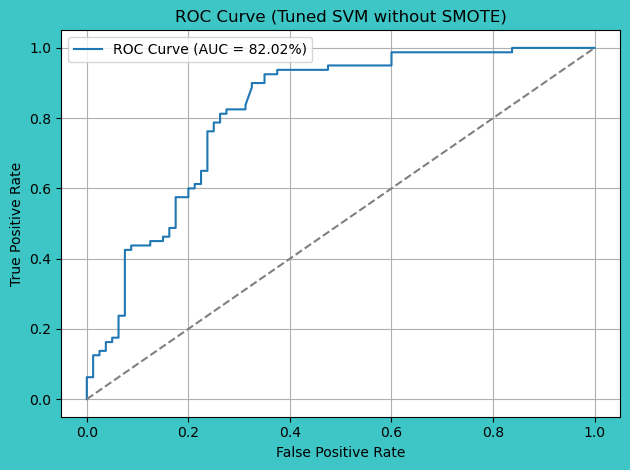

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.svm import SVC

# Load data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define Anemia
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

# Classify severity
def classify_anemia_severity(hb, age, gender):
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']), axis=1
)

# Normalize features
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Target
X = data_scaled
y = data['Heartdisease']

print("Total dataset size:", len(data))
print("Missing target values:", data['Heartdisease'].isna().sum())

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)
features_kept = [f for f, keep in zip(features, var_thresh.get_support()) if keep]
print("Features kept after removing constant features:", features_kept)

# Feature selection
selector = SelectKBest(score_func=f_classif, k=min(8, X_train_var.shape[1]))
X_train_selected = selector.fit_transform(X_train_var, y_train)
X_test_selected = selector.transform(X_test_var)
selected_features = [features_kept[i] for i in selector.get_support(indices=True)]
print("Selected features after SelectKBest:", selected_features)

# --- HYPERPARAMETER TUNING FOR SVC ---
print("\n--- SVC with GridSearchCV ---")

param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search_svc = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid_svc,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_svc.fit(X_train_selected, y_train)

model = grid_search_svc.best_estimator_

# --- Mean CV Accuracy & Std Dev ---
cv_accuracy_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='accuracy', n_jobs=-1)
mean_cv_accuracy = np.mean(cv_accuracy_scores) * 100
std_cv_accuracy = np.std(cv_accuracy_scores) * 100

print(f"\nValidation Accuracy Scores (5-fold CV): {[f'{score * 100:.2f}%' for score in cv_accuracy_scores]}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.2f}%")
print(f"Standard Deviation of CV Accuracy: {std_cv_accuracy:.2f}%")

# Predict on test set
predicted_proba = model.predict_proba(X_test_selected)[:, 1]
predicted_proba_percent = predicted_proba * 100
threshold = 0.5
predicted_class = (predicted_proba >= threshold).astype(int)

# Evaluation on test set (in %)
accuracy = accuracy_score(y_test, predicted_class) * 100
roc_auc = roc_auc_score(y_test, predicted_proba) * 100

print(f"\nTest Accuracy: {accuracy:.2f}%")
print(f"Test ROC AUC Score: {roc_auc:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Save predictions enriched with original categorical info
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

temp_data_for_display = pd.read_csv("actualdata.csv").loc[X_test.index].copy()

if temp_data_for_display['Gender'].dtype == object:
    temp_data_for_display['Gender'] = LabelEncoder().fit_transform(temp_data_for_display['Gender'])

predictions_df['Cholesterol'] = temp_data_for_display['Cholesterol']
predictions_df['Diabetes'] = temp_data_for_display['Diabetes']
predictions_df['BP'] = temp_data_for_display['BP']

predictions_df['Anemia_Severity'] = temp_data_for_display.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)
predictions_df['Anemia'] = temp_data_for_display.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

predictions_df.to_csv('predictions_svm_tuned_no_smote.csv')
print("Predictions saved to predictions_svm_tuned_no_smote.csv")

# Summary
print("Training class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

# Confusion matrix
cm = confusion_matrix(y_test, predicted_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')
disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Tuned SVM without SMOTE)")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, predicted_proba)
plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f}%)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Tuned SVM without SMOTE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
